In [42]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from xgboost import plot_importance
%matplotlib inline


# machine learning
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#warnings
import warnings
warnings.filterwarnings('ignore')

In [43]:
data = pd.read_csv('data_final.csv',index_col=0)

In [44]:
def split_data(data):
    #define X, y
    X = data.drop(['label'], axis=1).values
    y = data['label'].values
    #split into train and test to avoid overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [45]:
def model(model,X_train, y_train):
    '''
    xgboost classifier
    input: X_train, y_train
    output: xgboost model
    '''
    model = model
    model.fit(X_train, y_train)
    return model

In [46]:
def report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

In [47]:
def plot_confusion_matrix(y_test, y_pred,normalize=False):
    '''
    plot confusion matrix
    input: y_test,y_pred
    output: confusion matrix plot
    '''
    cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('XGBoost Confusion Matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.savefig('xgb_confusion_matrix.png')   

In [48]:
def plot_roc_auc(X_test,y_test, y_pred,model):
    xgb_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='XGBoost Classifier (area = %0.2f)' % xgb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('XGBoost_ROC.png')
    plt.show()

In [49]:
def plot_important_features(model):
    plot_importance(xgb)
    plt.savefig('xgb_importance.png')

In [50]:
def grid_search(param,x,y):
    '''
    grid search for xgboost
    with 5-fold cross validation
    '''
    model = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=550,
                                                       max_depth=4,
                                                       gamma=0.1,
                                                       learning_rate=0.1,
                                                       subsample=0.7,
                                                       colsample_bytree=0.7,
                                                       scoring='roc_auc'),                         
                         param_grid = param, 
                         scoring='roc_auc',
                         cv=5)
    model.fit(x,y)
    print(model.best_params_)
    print(model.best_score_)  
    return model

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     99362
           1       0.86      0.88      0.87     99719

   micro avg       0.87      0.87      0.87    199081
   macro avg       0.87      0.87      0.87    199081
weighted avg       0.87      0.87      0.87    199081



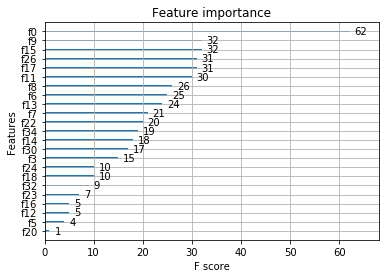

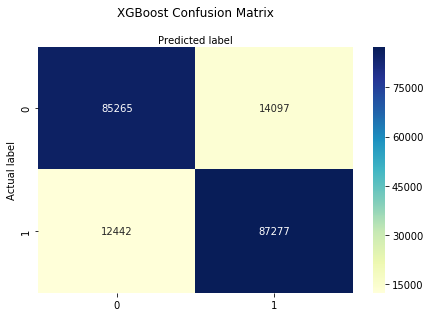

<Figure size 432x288 with 0 Axes>

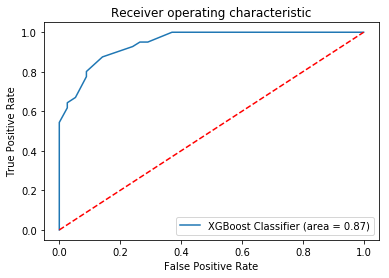

In [51]:
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = split_data(data)
    #model before grid search
    xgb = model(xgb.XGBClassifier(),X_train, y_train)
    y_pred = xgb.predict(X_test)
    report(y_test, y_pred)
    #grid search
    #param = {'n_estimators': [400, 500, 600, 700, 800],
    #         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
    #         'min_child_weight': [1, 2, 3, 4, 5, 6],
    #         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
    #grid_search(grid_search(param,X_train,y_train))
    #plot
    plot_important_features(xgb)
    plot_confusion_matrix(y_test, y_pred,normalize=False)
    plot_roc_auc(X_test,y_test, y_pred,xgb)